### K-means


In [ ]:
#import packages
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter

#load data
url_ratings = "https://files.grouplens.org/datasets/rating-disposition-2023/ratings.csv" #from url
ratings = pd.read_csv(url_ratings)
movies = pd.read_csv('movies.csv', sep=',') #from loaded file
movies = movies.drop_duplicates('movieId') #delete duplicated rows about the column 'movieId'

#keep only ratings for which related 'movieId' exists in the column 'movieId' of movies dataset
filtered_ratings = ratings[ratings['movieId'].isin(movies['movieId'])]

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
filtered_ratings.head()

,userId,movieId,rating,tstamp
0,206,4803,4.0,2003-04-07 13:52:01
1,5073,72731,4.0,2020-02-19 16:07:53
2,4739,91653,4.0,2020-12-28 15:35:58
3,535,3005,3.0,2008-12-26 05:38:11
4,465,4776,3.0,2008-08-13 20:22:36


In [ ]:
#select the set of missing movies (movies that have not been rated)
missing_movies = set(movies['movieId']) - set(filtered_ratings['movieId'])
#list of the movies to keep from the movies dataframe
moviesId = list(set(movies['movieId']) - set(missing_movies))
#keep only the list of movies above
movies = movies[movies['movieId'].isin(moviesId)]

In [ ]:
len(movies)

65107

In [ ]:
#common genres to delete from the 'genres' column
to_delete = ["Comedy", "Drama", "Thriller", "Action", "Adventure"]
#remove common genres from the 'genres' column
for d in to_delete:
    movies['genres'] = movies['genres'].str.replace(d, '')
#adjust output
movies['genres'] = movies['genres'].str.strip('|')
movies['genres'] = movies['genres'].str.replace(r'\|+', '|')
movies.head()

<ipython-input-6-1b3f488406e2>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['genres'] = movies['genres'].str.replace(r'\|+', '|')


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children|Fantasy
1,2,Jumanji (1995),Children|Fantasy
2,3,Grumpier Old Men (1995),Romance
3,4,Waiting to Exhale (1995),Romance
4,5,Father of the Bride Part II (1995),


In [ ]:
#create the movie_user_matrix using pivot_table
movie_user_matrix = filtered_ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

In [ ]:
movie_user_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,5.0,3.0,4.0,4.5,0.0,4.0,2.5,...,5.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,3.0,0.0,2.5,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#ensure that the number of rows of the matrix and the len of the movies dataframe are the same
#(this is needed to be able to assign clusters later adding a column with the cluster number to the movies
#dataframe)
print(len(movie_user_matrix), len(movies))

65107 65107


In [ ]:
#create the sparse matrix corresponding to the movie_user_matrix to speed up the k-means since k-means
#is designed to work with sparse data structure
#sparse_movie_user_matrix = csr_matrix(movie_user_matrix.values)

In [ ]:
inertia_values = [] #store inertia values to plot the elbow method
k_values = range(1, 21) #20 is the max number of clusters we try
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init = 'auto')
    kmeans.fit(movie_user_matrix)
    inertia_values.append(kmeans.inertia_)

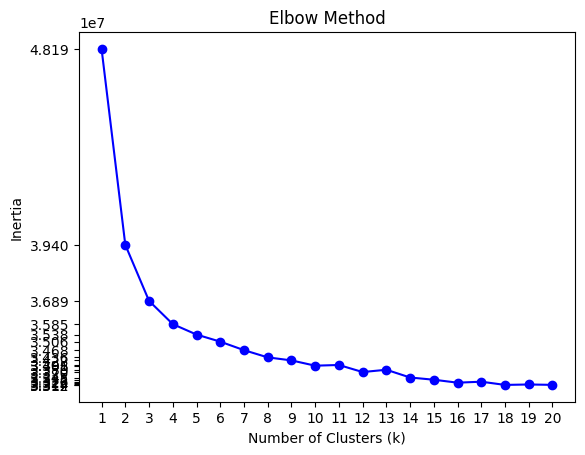

In [ ]:
#plot the elbow method wjich helps to chose a number of clusters
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xticks(k_values)
plt.yticks(inertia_values)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

The graph above shows the representation of the elbow method where on the X axis there is the number of clusters and on the Y axis the corresponding value of the inertia. Since there seems not to be a clear 'elbow' we can try to choose k by considering the value of k from where the corrispinding inertia starts to decrease much slower than before. The identified value is k = 3

In [ ]:
k = 3 #chosen k based on the elbow method
#apply k-means with the 'true' number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init = 'auto')
#predict clusters
cluster_assignments = kmeans.fit_predict(movie_user_matrix)

In [ ]:
#create a new clumn of the movies dataframe to allocate the number of the cluster assigned to the movie
#from the k-means algorithm
movies['cluster'] = cluster_assignments

In [ ]:
movies.head()

,movieId,title,genres,cluster
0,1,Toy Story (1995),Animation|Children|Fantasy,1
1,2,Jumanji (1995),Children|Fantasy,1
2,3,Grumpier Old Men (1995),Romance,2
3,4,Waiting to Exhale (1995),Romance,2
4,5,Father of the Bride Part II (1995),,0


In [ ]:
#create a dictionary for the frequency of each genre in each of the two clusters
cluster_genres_frequency = {}

#iterate over each cluster
for cluster in range(k):
    #select the cluster
    cluster_movies = movies[movies['cluster'] == cluster]
    #isolate the words related to genre
    genres = "|".join(cluster_movies['genres']).split('|')
    #genres = [genre for genre in genres if genre not in delete_words]
    #count the genres
    genres_counter = Counter(genres)
    #delate the most common geres
    genres_counter = {genre: count for genre, count in genres_counter.items()
                     if genre not in ['']}
    #compute the frequency of each genre for each cluster
    cluster_genres_frequency[cluster] = genres_counter

#print the result
for cluster, frequencies in cluster_genres_frequency.items():
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)
    print(f"Cluster {cluster}: {sorted_frequencies}")

Cluster 0: [('Crime', 350), ('Romance', 343), ('Sci-Fi', 317), ('Fantasy', 225), ('Horror', 203), ('Mystery', 188), ('Children', 164), ('Animation', 152), ('War', 91), ('IMAX', 70), ('Musical', 63), ('Documentary', 44), ('Western', 42), ('Film-Noir', 21), ('(no genres listed)', 7)]
Cluster 1: [('Sci-Fi', 116), ('Crime', 78), ('Fantasy', 67), ('IMAX', 52), ('Mystery', 45), ('Romance', 43), ('Animation', 38), ('Children', 36), ('Horror', 25), ('War', 24), ('Musical', 10), ('Western', 6), ('Film-Noir', 4)]
Cluster 2: [('Romance', 7503), ('Documentary', 6722), ('Horror', 6564), ('Crime', 4947), ('(no genres listed)', 4335), ('Animation', 3615), ('Sci-Fi', 3565), ('Children', 3238), ('Mystery', 2840), ('Fantasy', 2814), ('War', 1767), ('Western', 1090), ('Musical', 892), ('Film-Noir', 308), ('IMAX', 71)]


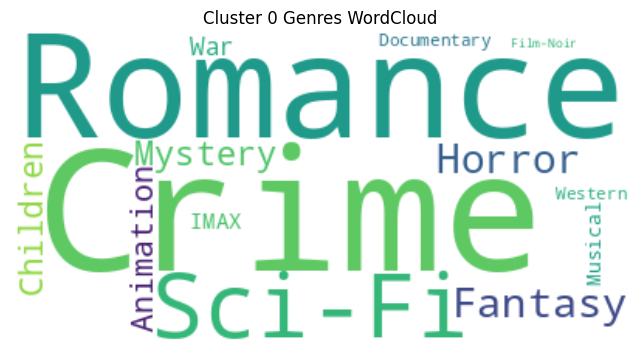

-----------------------------------------------------------------------------------


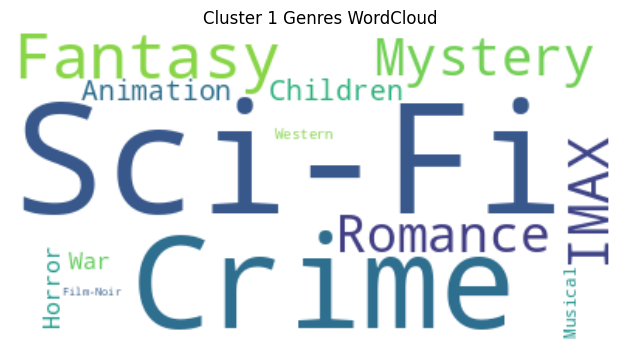

-----------------------------------------------------------------------------------


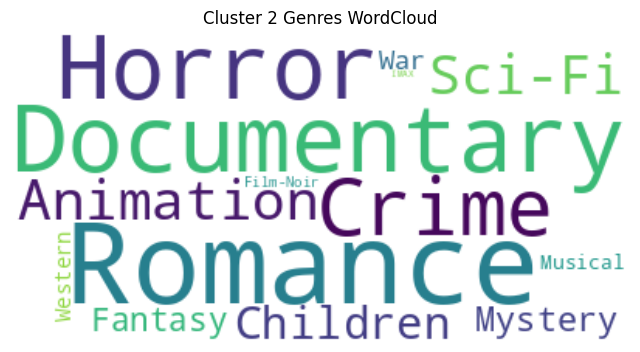

-----------------------------------------------------------------------------------


In [ ]:
#create a dictionary for the frequency of each genre in each of the two clusters
cluster_genres_frequency = {}

#iterate over each cluster
for cluster in range(k):
    #select the cluster
    cluster_movies = movies[movies['cluster'] == cluster]
    #isolate the words related to genre
    genres = "|".join(cluster_movies['genres']).split('|')
    #genres = [genre for genre in genres if genre not in delete_words]
    #count the genres
    genres_counter = Counter(genres)
    #delate the most common geres
    genres_counter = {genre: count for genre, count in genres_counter.items()
                     if genre not in ['', '(no genres listed)']}
    #compute the frequency of each genre for each cluster
    cluster_genres_frequency[cluster] = genres_counter


    # Create WordCloud for each cluster
    wordcloud = WordCloud(stopwords= ENGLISH_STOP_WORDS, background_color='white').generate_from_frequencies(genres_counter)

    # Plot the WordCloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster} Genres WordCloud')
    plt.axis("off")
    plt.show()
    print('-----------------------------------------------------------------------------------')

As we can see, there are some overlaps. This is because each movie has different genres that allow it to be described someway. The most frequent genres for Cluster 0 are Romance, Crime and Sci-Fi, for Cluster 1 are Sci-Fi, Crime and Fantasy while for Cluster 2 Romance, Documentary and Horror.

### Truncated SVD + k-means

In [ ]:
#import more packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


#load data
url_ratings = "https://files.grouplens.org/datasets/rating-disposition-2023/ratings.csv"
ratings = pd.read_csv(url_ratings)
movies = pd.read_csv('movies.csv', sep=',')
movies = movies.drop_duplicates('movieId')

#pre-process data as before
filtered_ratings = ratings[ratings['movieId'].isin(movies['movieId'])]

In [ ]:
missing_movies = set(movies['movieId']) - set(filtered_ratings['movieId'])
moviesId = list(set(movies['movieId']) - set(missing_movies))
movies = movies[movies['movieId'].isin(moviesId)]

In [ ]:
to_delete = ["Comedy", "Drama", "Thriller", "Action", "Adventure"]
for d in to_delete:
    movies['genres'] = movies['genres'].str.replace(d, '')

movies['genres'] = movies['genres'].str.strip('|')
movies['genres'] = movies['genres'].str.replace(r'\|+', '|')
movies.head()

<ipython-input-5-da797fe8a5cc>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['genres'] = movies['genres'].str.replace(r'\|+', '|')


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children|Fantasy
1,2,Jumanji (1995),Children|Fantasy
2,3,Grumpier Old Men (1995),Romance
3,4,Waiting to Exhale (1995),Romance
4,5,Father of the Bride Part II (1995),


In [ ]:
#compute movie_user matrices
movie_user_matrix = filtered_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

In [ ]:
n_components = 20 #max value considered for the number of components of svd
explained_variance_values = [] #store values for the plot

n_components_values = range(1, n_components+1)

for n_components in n_components_values:
    #perform truncated svd with different number of components
    svd = TruncatedSVD(n_components=n_components)
    #normalize each sample to have unit norm
    normalizer = Normalizer(copy=False)
    svd.fit(movie_user_matrix)
    explained_variance_values = svd.explained_variance_ratio_

In [ ]:
#sort values of explained variance ration in descending order
explained_variance_values = sorted(explained_variance_values, reverse=True)

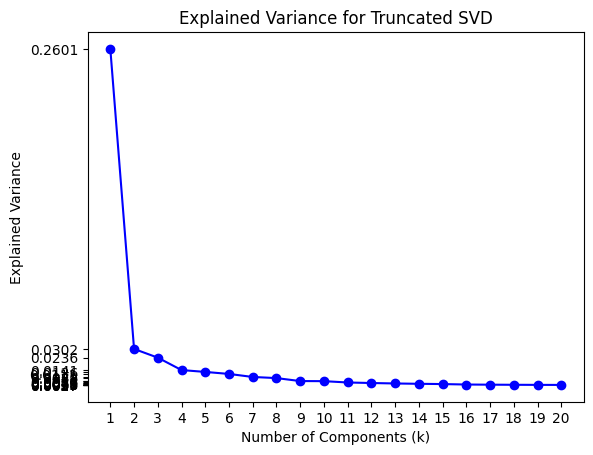

In [ ]:
# Plot the explained variance curve
plt.plot(n_components_values, explained_variance_values , marker='o', linestyle='-', color='b')
plt.xticks(n_components_values)
plt.yticks(explained_variance_values)
plt.title('Explained Variance for Truncated SVD')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance')
plt.show()

From the graph above, differently from the one derived from the k-means, the 'elbow' very clearly defines the 'true' value of the number of clsters k. In this case k = 2 represents the number of components that retain enough variance to summarize the the information since adding more components provides diminishing returns in terms of explained variance.

In [ ]:
k = 2  #'true' k
#perform k-means with k = 2
kmeans = KMeans(n_clusters=k, n_init = 'auto', max_iter = 100, init = 'k-means++')
#predict clusters
cluster_assignments = kmeans.fit_predict(movie_user_matrix)

#add cluster assignments to the movies dataframe
movies['cluster'] = cluster_assignments

In [ ]:
movies.head()

,movieId,title,genres,cluster
0,1,Toy Story (1995),Animation|Children|Fantasy,1
1,2,Jumanji (1995),Children|Fantasy,1
2,3,Grumpier Old Men (1995),Romance,0
3,4,Waiting to Exhale (1995),Romance,0
4,5,Father of the Bride Part II (1995),,0


In [ ]:
#create a dictionary for the frequency of each genre in each of the two clusters
cluster_genres_frequency = {}

#iterate over each cluster
for cluster in range(k):
    #select the cluster
    cluster_movies = movies[movies['cluster'] == cluster]
    #isolate the words related to genre
    genres = "|".join(cluster_movies['genres']).split('|')
    #count the genres
    genres_counter = Counter(genres)
    #delate the most common geres
    genres_counter = {genre: count for genre, count in genres_counter.items()
                     if genre not in ['', '(no genres listed)']}
    #compute the frequency of each genre for each cluster
    cluster_genres_frequency[cluster] = genres_counter

#print the result
for cluster, frequencies in cluster_genres_frequency.items():
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)
    print(f"Cluster {cluster}: {sorted_frequencies}")

Cluster 0: [('Romance', 7726), ('Documentary', 6761), ('Horror', 6706), ('Crime', 5178), ('Sci-Fi', 3749), ('Animation', 3705), ('Children', 3340), ('Mystery', 2976), ('Fantasy', 2958), ('War', 1827), ('Western', 1116), ('Musical', 925), ('Film-Noir', 321), ('IMAX', 115)]
Cluster 1: [('Sci-Fi', 249), ('Crime', 197), ('Romance', 163), ('Fantasy', 148), ('Animation', 100), ('Children', 98), ('Mystery', 97), ('Horror', 86), ('IMAX', 78), ('War', 55), ('Musical', 40), ('Western', 22), ('Film-Noir', 12), ('Documentary', 5)]


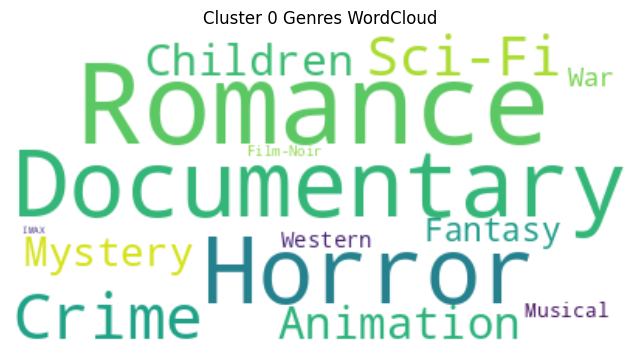

-----------------------------------------------------------------------------------


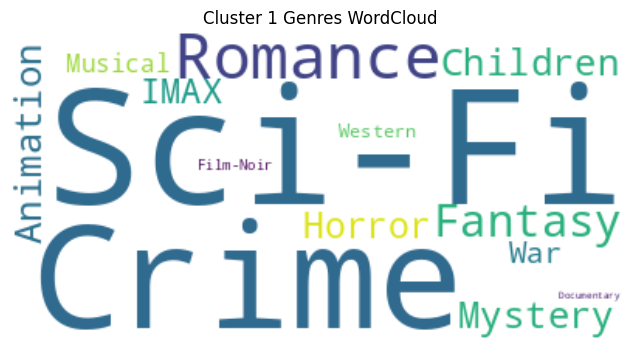

-----------------------------------------------------------------------------------


In [ ]:
#create a dictionary for the frequency of each genre in each of the two clusters
cluster_genres_frequency = {}

#iterate over each cluster
for cluster in range(k):
    #select the cluster
    cluster_movies = movies[movies['cluster'] == cluster]
    #isolate the words related to genre
    genres = "|".join(cluster_movies['genres']).split('|')
    #count the genres
    genres_counter = Counter(genres)
    #delate the most common geres
    genres_counter = {genre: count for genre, count in genres_counter.items()
                     if genre not in ['', '(no genres listed)']}
    #compute the frequency of each genre for each cluster
    cluster_genres_frequency[cluster] = genres_counter


    # Create WordCloud for each cluster
    wordcloud = WordCloud(stopwords= ENGLISH_STOP_WORDS, background_color='white').generate_from_frequencies(genres_counter)

    # Plot the WordCloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster} Genres WordCloud')
    plt.axis("off")
    plt.show()
    print('-----------------------------------------------------------------------------------')

The clusters defined by the truncatedSVD + k-means are meanly made of Romance, Documentary and Horror if we consider Cluster 0 and Sci-Fi and Crime if we consider Cluster 1.

If we want to compare the results, we can say that:


*   **k-means** is much slower than truncatedSVD and identifies, even if not clearly enough, 3 clusters which can be seen to have some overlaps.
*   **TruncatedSVD + k-means** is faster and clearly identifies two clusters with less overlaps which suggests a better clusterization.



Since the clustering is performed starting from the movie_user matrix and it is based on ratings, the Wordclouds reflect the relationship between ratings and genres of the movies we have taken into account.